# TP2 - Topic Modeling

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/figure2.png?raw=1" width="1000">

Le <i>Topic Modeling</i> est une approche statistique qui permet de faire √©merger des topics abstraits d'un corpus de documents. 
Cette approche permet √©galement d'analyser la structure du corpus de documents en regroupant ceux qui pr√©sentent des topics similaires puis en analysant ces groupes, ou en analysant les caract√©ristiques des topics identifi√©s.

La plupart des mod√®les de <i>Topic Modeling</i> s'appuient sur des hypoth√®ses de mod√©lisations similaires:
* Chaque document est mod√©lis√© comme une distribution sur les _topics_ ;
* Chaque _topic_ est mod√©lis√© comme une distribution sur les mots du vocabulaire.

On a illustr√© cette mod√©lisation ci-dessous. Ainsi chaque document est repr√©sent√© par une distribution sur une variable latente (on dit aussi cach√©e), les _topics_. Ces derniers ne sont pas "observ√©s" : en pratique chaque document est d√©crit par une distribution sur les mots du vocabulaire. **L'objectif des mod√®les de _topics_ est donc de caract√©riser la forme de cette variable latente.** Nous allons voir plusieurs m√©thodes et mod√®les proposant cette caract√©risation.

Ci-dessous, on a illustr√© l'intuition derri√®re cette mod√©lisation. Chaque document va contenir plusieurs _topics_, par exemple, les transports et les vacances. On retrouvera donc des mots caract√©ristiques de ces topic: "avion", "plage", "cong√©s" ... Des documents qui abordent des _topics_ proches contiendront donc un vocabulaire proche. Ainsi chaque _topic_ pourra √™tre caract√©ris√© par des mots saillants qui lui sont sp√©cifiques.



<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/lda-idee.png?raw=true" width="1000">


In [1]:
%%capture

# ‚ö†Ô∏è Execute only if running in Colab
if 'google.colab' in str(get_ipython()):
  IN_COLAB = True
else:
  IN_COLAB = False

if IN_COLAB:
  !pip install -q scikit-learn==0.23.2 nltk==3.5 unidecode pysrt
  !pip install --no-deps pyLDAvis==3.3.1
  !pip install --no-deps funcy==1.16
  !python3 -m spacy download fr_core_news_md

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
import numpy as np
import os
from pyLDAvis import sklearn as sklearn_lda
import pickle
import pyLDAvis
import pysrt
import re
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.fr.stop_words import STOP_WORDS
from tqdm.auto import tqdm
import unidecode
import urllib.request

# IPython automatically reload all changed code
%load_ext autoreload
%autoreload 2

# Inline Figures with matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python

In [3]:
# import extrenal modules

repo_url = 'https://raw.githubusercontent.com/AntoineSimoulin/m2-data-sciences/master/'
_ = urllib.request.urlretrieve(repo_url + 'src/plot_dirichlet.py', 'plot_dirichlet.py')

for season in range(1, 9):
  dir = './data/S{:02d}'.format(season)
  if not os.path.exists(dir):
    os.makedirs(dir)
    for episode in range(1, 11):
      try:
        _ = urllib.request.urlretrieve(
            repo_url + 'TP2%20-%20Text%20Mining/sous-titres-got/S{:02d}/E{:02d}.srt'.format(season, episode), 
            './data/S{:02d}/E{:02d}.srt'.format(season, episode))
      except:
        pass

from plot_dirichlet import Dirichlet, draw_pdf_contours

## Latent Semantic Analysis (LSA)

Le mod√®le Latent Semantic Analysis (LSA) ([Landauer & Dumais, 1997](#landauer-dumais-1997)) cherche √† d√©composer la matrice de d√©composition des documents selon le vocabulaire en deux matrices : une matrice de d√©composition des documents selon les topics et une matrice de distribution des topics selon les mots du vocabulaires.

On commencer donc par repr√©senter les documents selon une distribution sur le vocabulaire. Pour cela on utilise le Tf-Idf qui permet de repr√©senter chaque document du corpus comme une distribution sur le vocabulaire, en pratique, un vecteur de la taille du vocabulaire. On peut donc repr√©senter le corpus comme une matrice de taille $(M, V)$ avec $M$ le nombre de documents dans le corpus et $V$ la taille du vocabulaire. Cette repr√©sentation est illustr√©e ci-dessous. 

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/bow.png?raw=true" width="500">

On va ensuite d√©composer la matrice en utilisant **d√©composition en valeurs singuli√®res** (en anglais Singular Value Decomposition, [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition)). On peut interpr√©ter la SVD comme la g√©n√©ralisation de la diagonalisation d'une matrice normale a des matrices arbitraires. Ainsi une matrice $A$ de taille $n \times m$ peut √™tre factoris√©e sous la forme $A = U \Sigma V^T$, avec $U$ et $V$ des matrices orthogonales de tailles respectives $m \times m$ et $n \times n$ et $\Sigma$ une martice rectangulaire diagonale de taille $m \times n$. 

En pratique, il est peu commun de d√©composer compl√©tement la matrice, on utilise plut√¥t la <a href="https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD"><i>Trucated Singular Value Decomposition</i></a> qui permet de ne calculer que les $t$ premi√®res valeurs singuli√®res. Dans ce cas, on ne consid√®re que les $t$ premi√®res colonnes de la matrice $U$ et les $t$ premi√®res lignes de la matrice $V$. On a ainsi :

$$A_t = U_t \Sigma_t V_t^T$$

Avec $U_t$ de taille $m \times t$ et $V_t$ de taille $n \times t$. Cette d√©composition est illustr√©e ci-dessous.

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/svd-formule.png?raw=true" width="1000">

On illustre ci-dessous l'application de la d√©composition √† notre matrice Tf-Idf. La matrice $U_t$ apparait comme la matrice <i>document-topic</i> qui d√©finit chaque document comme une distribution de topic. La matrice $V_t$ apparait comme la matrice <i>terme-topic</i> qui d√©finit chaque topic comme une distribution sur le vocabulaire.

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/svd-illustration.png?raw=true" width="1000">

On peut aussi interpr√©ter le <i>Topic Modeling</i> comme une approche de r√©duction de dimension. En effet, la matrice Tf-Idf a plusieurs d√©fauts : Elle est de grande dimension (la taille du vocabulaire), elle est _sparse_ _i.e._ beaucoup d'entr√©es sont √† z√©ro, elle est tr√®s bruit√©e et les information sont redondantes selon plusieurs dimensions. La d√©composition permet ainsi de la factoriser. Les deux matrices r√©sultantes permetent d'utiliser la similarit√© cosinus pour comparer simplement des doccuments ou des mots.

## Probabilistic Latent Semantic Analysis (pLSA)

La LSA est une m√©thode tr√®s efficace. N√©anmoins en pratique, les topics r√©sultants sont parfois difficiles √† interpr√©ter. 
La m√©thode n√©cessite un corpus important pour obtenir des r√©sultats pertinents.

La methode de Probabilistic Latent Semantic Analysis (pLSA) remplace ainsi la SVD par une approche probabiliste.
Il s'agit d'un mod√®le **g√©n√©ratif**, qui permet de g√©n√©rer les documents que l'on observe. 
En pratique il permet de g√©n√©rer la matrice Bag-of-words qui repr√©sente le corpus. Le mod√®le ne tient donc pas compte de l'ordre des mots.

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/plda_principe.png?raw=true" width="1000">


Les mod√®les graphiques repr√©sentent les variables al√©atoies comme des noeuds. Les arcs entre les noeuds indiquent les variables potentiellement d√©pendantes. Les variables observ√©es sont gris√©es. Dans la figure ci-dessous, les noeuds $ X_{1,...,N}$ sont observ√©s alors que le noeud $Y$ est une variable latente. Dans cet exemple, les variables observ√©es d√©pendent de cette variable latente. Les rectangles synth√©tisent la r√©plication de plusieurs structures. Un rectangle r√©sume donc plusieurs variables $X_n$ avec $n \in N$.

La structure du graph d√©finie les d√©pendances conditionnelles entre l'ensemble des variables. Par exemple dans le graph ci-dessous, on a $p(Y,X_{1},...,X_{N})=p(Y)\prod _{n=1}^{N}p(X_{n}|Y)$.

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/graphical_model.png?raw=1" width="500">

Le fonctionnement du mod√®le est d√©taill√© selon la repr√©sentation graphique suivante :
* Etant donn√© un document $d$, un topic $z$ est pr√©sent dans le document avec une probabilit√© $P(z|d)$. 
* Etant donn√© un topic $z$, un mot est g√©n√©r√© selon la probabilit√© conditionnelle $P(w|z)$.

La probabilit√© jointe d'observer un mot dans un document s'exprime donc :

$$P(D,W)=P(D)\sum_ZP(Z|D)P(W|Z)$$

Ici, $P(D)$, $P(Z|D)$ et $P(W|Z)$ sont des param√®tres du mod√®le. $P(D)$ peut √™tre  calcul√© directement √† partir du corpus.
$P(Z|D)$ et $P(W|Z)$ sont mod√©lis√©s par des distributions multinomiales qui peuvent √™tre entrain√©s par la m√©thode [EM](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm).

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/plsa.png?raw=true" width="500">

On peut intepr√©ter la probabilit√© selon la proc√©dure suivante : On commence par un document avec la probabilit√© $P(D)$, on g√©n√®re un _topic_ avec la probabilit√© $P(Z|D)$ puis on g√©n√®re un mot avec la probabilit√© $P(W|Z)$. En pratique, on apprend donc les param√®tres de notre mod√®les qui permetent d'expliquer qu mieux le corpus observ√© comme illustr√© ci-dessous.

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/plda_inference.png?raw=true" width="1000">

On peut aussi exprimer la probabilit√© jointe selon la d√©composition suivante :

$$P(D,W)=\sum_ZP(Z)P(D|Z)P(W|Z)$$

Dans cette mod√©lisation, on commence par le _topic_ avec $P(Z)$ et on g√©n√®re ensuite ind√©pendamment le document avec $P(D|Z)$ et le mot avec $P(W|Z)$.

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/plda_process.png?raw=true" width="500">

L'int√©r√™t de cette param√©trisation, c'est qu'elle fait appraitre un parall√®le avec la LSA.

La probabilit√© du topic $P(Z)$ correspond √† la matrice diagonale  de la d√©composition en valeurs singuli√®ers. La probabilit√© d'un document en donction du topic $P(D|Z)$ correpond √† la matrice document-_topic_  $U$ et la probabilit√© d'un mot en fonction du _topic_ $P(W|Z)$ correpond √† la matricec terme-_topic_ $V$. Les deux approches pr√©sentent donc des similarit√©s, la pLSA apporte un traitement statistique des _topics_ et des mots par rapport √† la LSA.

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/plsa-formule.png?raw=true" width="500">


## Latent Dirichlet Allocation (LDA)

La pLSA a un certain nombre dee contraintes :
* Il n'y a pas de param√®tres pour mod√©liser $P(D)$, on ne peut donc pas assigner de probabilit√© √† de nouveaux documents
* Le nombre de param√®tres grandit lin√©airement avec le nombre de documents dans le corpus, le mod√®le est donc sujet √† l'_overfitting_.

En pratique, la pLSA  n'est donc pas souvent utilis√©e, on lui pr√©f√®re g√©n√©ralement la Latent Dirichlet Allocation (LDA) ([Blei et al., 2001](#blei-2001)). La LDA utilise des prior de dirichlet pour les distributions des documents selon les _topics_ et _topics_ selon les mots, ce qui lui donne de meilleures propri√©t√©s de g√©n√©ralisation: on peut g√©n√©raliser pour de nouveaux documents.


### La distribution de Dirichlet

La [distribution de Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution) est g√©n√©ralement not√©e $Dir(\alpha)$. Il s'agit d'une famille de lois de probabilit√©s continues pour des variables al√©atoires multinomiales. Cette loi (ou encore distribution) est param√©tr√©e par le vecteur ${\bf \alpha}$ de nombres r√©els positifs. La taille du vecteur ${\bf \alpha}$ indique la dimension de la distribution. Ce type de distribution est souvent utilis√©e comme distribution √† priori dans les mod√®les Bay√©siens. Sans rentrer dans les d√©tails, voici quelques caraact√©ristiques de la distribution de Dirichlet :

* La distribution est d√©finie sur un simplex de vecteurs positifs dont la somme est √©gale √† 1 
* Sa densit√© est caract√©ris√©e par : $P(\theta |{\overrightarrow {\alpha }})={\frac {\Gamma (\Sigma _{i}\alpha _{i})f}{\Pi _{i}\Gamma (\alpha _{i})}}\Pi _{i}\theta _{i}^{\alpha _{i}-1}$
* En pratique, si toutes les dimensions de ${\bf \alpha}$ ont des valeurs similaires, la distribution est plus √©tal√©e. Elle devient plus concentr√©e pour des valeurs plus importantes de ${\bf \alpha}$.

La distribution est illustr√©e ci-dessous pour des valeurs des valeurs de ${\bf \alpha}$ 

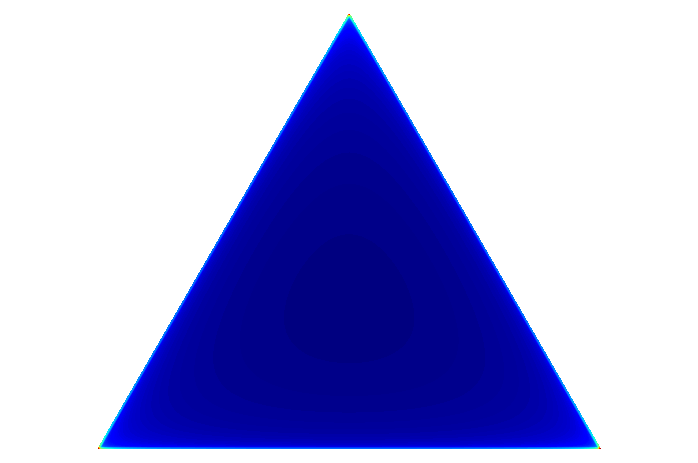

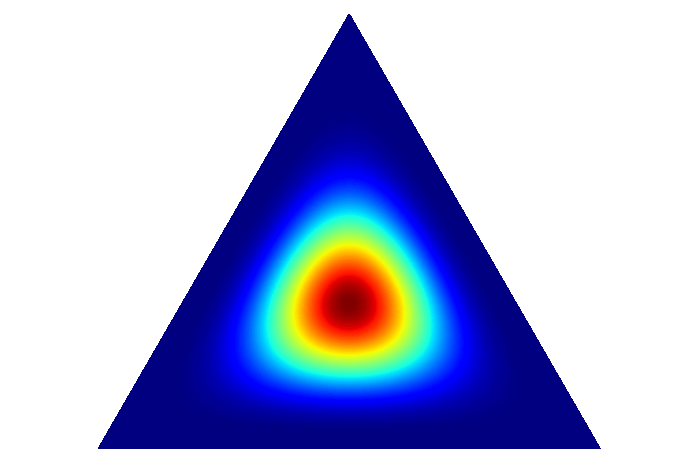

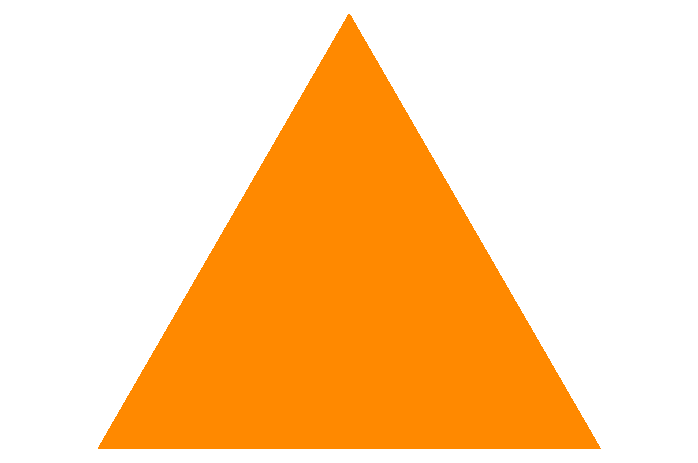

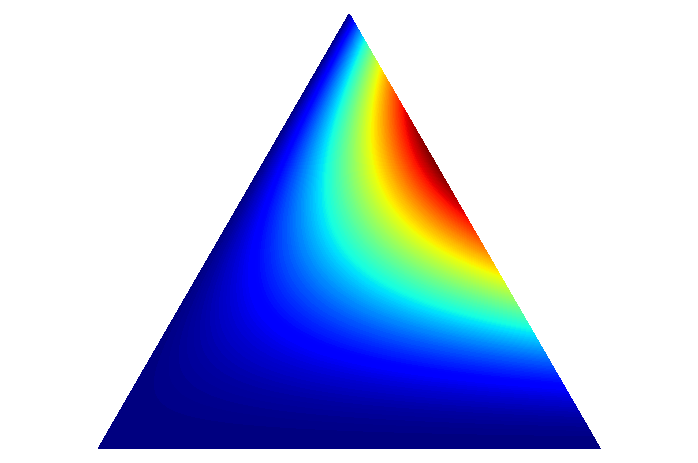

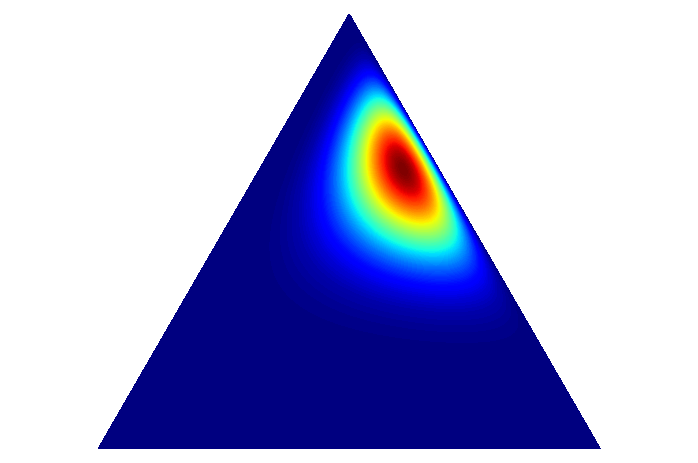

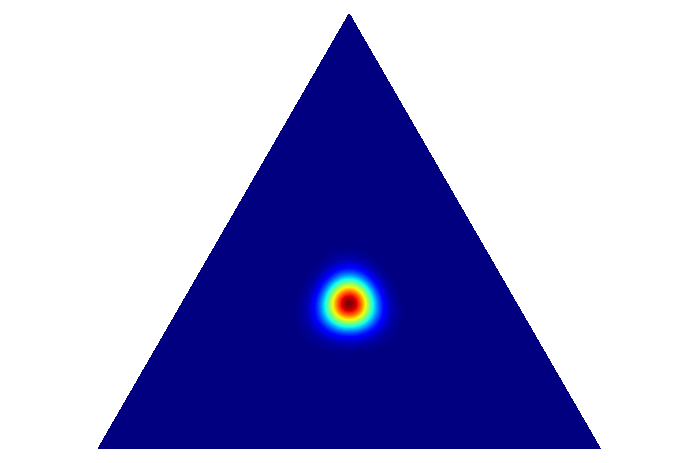

In [4]:
for alpha in [(0.85, 0.85, 0.85), (5, 5, 5), (1, 1, 1), (1, 2, 3), (2, 5, 10), (50, 50, 50)]:
    draw_pdf_contours(Dirichlet(alpha))

Cette distribution a des avantages pratiques. En particulier, on s'attend √† ce que les documents du corpus contiennent un _topic_ "majoritaire". Ils ne sont pas g√©n√©r√©s selon une distribution 25% vacances, 25% sport, 25% √©lections, 25% transports mais plut√¥t des distributions du type 85% vacances, 5% sport, 5% √©lections, 5% transports. Ces distributions vont donc attribu√© un poids important √† un certain _topic_. C'est justement ce que permet de r√©aliser la distribution de Dirichlet avec de faibles valeurs de $\alpha$.

La repr√©sentation garphique du mod√®le est propos√©e ci-dessous. La LDA suppose le proc√©ssus g√©n√©ratif suivant pour chaque document $W$ dans le corpus $D$.


> 1. On choisit $\theta \sim Dir(\alpha )$
> 2. Pour chaque document dans le corpus:
>     * Pour chacun des $N$ mots $w_{n}$ dans le document :
>        * on g√©n√®re un topic $z_{n}\sim Multinomial(\theta )$
>        * on g√©n√®re un mot $w_{n}$ $p(w_{n}|z_{n},B)$ selon une loi multinimoale conditionn√©e par le topic $z_{n}$.


Our goal here is to estimate parameters œÜ, Œ∏ to maximize p(w; Œ±, Œ≤). The main advantage of LDA over pLSA is that it generalizes well for unseen documents.

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP2%20-%20Text%20Mining/figures/lda_graph.png?raw=true" width="700">

## 3. Utilisation des librairies

On va chercher √† analyser les th√®mes de la S√©rie Game Of Thrones. On utilise pour √ßa les sous-titres de l'ensemble des saisons qui ont √©t√© r√©cup√©r√©s sur le site https://www.sous-titres.eu/series/game_of_thrones.html.

In [5]:
def create_subtitle_file_dict(subtitles_dir):
    "Retourne les chemins vers les fichiers de sous titres"
    subtitles_file_path = {}
    for path, _, files in os.walk(subtitles_dir):
        for name in files:
            episode_name = '_'.join([os.path.basename(path), name.split('.')[0]])
            subtitles_file_path[episode_name] = os.path.join(path, name)
    return subtitles_file_path

def parse_srt_file(srt_file, encoding='iso-8859-1'):
    "Lit un ficher de sous titres au format rst"
    subs = pysrt.open(srt_file, encoding=encoding)
    text = ' '.join([' '.join(sub.text.split('\n')) for sub in subs])
    return text

def create_corpus(subtitles_file_path):
    "Cr√©er un corpus √† partir de tous les fichiers rst dans un dossier"
    corpus = []
    for _, v in subtitles_file_path.items():
        if v.endswith('srt'):
            corpus.append(parse_srt_file(v))
    return corpus

def split_episodes(corpus):
    "split chaque episode en un sous √©pisode de 400 mots."
    corpus_split = []
    for episode in corpus:
        episode_words = episode.split()
        i = 0
        while i < len(episode_words):
            corpus_split.append(' '.join(episode_words[i:i+400]))
            i+=400
    return corpus_split

In [6]:
subtitles_file_path = create_subtitle_file_dict('./data/')

In [7]:
episode_1_txt = parse_srt_file(subtitles_file_path['S01_E01'])

In [8]:
print(episode_1_txt[:100])

Doucement. Que croyais-tu ? Ce sont des sauvages. L'un vole une ch√®vre √† l'autre, et ils finissent p


In [9]:
corpus = create_corpus(subtitles_file_path)
corpus = split_episodes(corpus)

In [10]:
len(corpus)

690

In [11]:
corpus[0][:100]

'Vous avez connu des jours meilleurs. Une autre visite ? Vous √™tes mon dernier ami. Non, non, beaucou'

<hr>
<div class="alert alert-info" role="alert">
    <p><b>üìù Exercice :</b> Nettoyer le corpus pour enlever les accents, mettre le texte en minuscule, enlever la ponctuation et les doubles espaces. Eventuellement pour le stemming.</p>
</div>
<hr> 

In [12]:
stemmer = FrenchStemmer()

def clean_corpus(corpus):
    for i in range(len(corpus)):
        corpus[i] = unidecode.unidecode(corpus[i])
        corpus[i] = re.sub(r'[^\w\s]', ' ', corpus[i])
        corpus[i] = corpus[i].lower()
        corpus[i] = re.sub(r'\s{2,}', ' ', corpus[i])
        # corpus[i] = ' '.join([stemmer.stem(x) for x in corpus[i].split()])
    return corpus

In [13]:
corpus = clean_corpus(corpus)

In [14]:
corpus[0][:100]

'vous avez connu des jours meilleurs une autre visite vous etes mon dernier ami non non beaucoup d au'

In [15]:
len(corpus)

690

In [16]:
def tokenize_corpus(corpus):
    tokens = []
    for sentence in corpus.split('\n'):
        tokens.append(nltk.word_tokenize(sentence))
    return tokens

In [17]:
sentence_length = [len(x.split()) for x in corpus]

In [18]:
np.mean(sentence_length), np.std(sentence_length)

(394.3985507246377, 76.07669088788185)

<hr>
<div class="alert alert-info" role="alert">
    <p><b>üìù Exercice :</b> Vectorizer le corpus en utilisant la m√©thode Bag-Of-Words.</p>
</div>
<hr> 

In [19]:

# Initialise the count vectorizer
count_vectorizer = CountVectorizer(max_features=2000,
                                   stop_words=STOP_WORDS,
                                   max_df=0.9,
                                   min_df=20)

count_data = count_vectorizer.fit_transform(corpus)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu', 'quelqu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [20]:
len(corpus)

690

In [21]:
# Faire varier les param√®tres ci-dessous
number_topics = 15
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

LatentDirichletAllocation(n_components=15, n_jobs=-1)

In [22]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [23]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
adaptation brothers titrage dubbing blandine menard maville clotilde qu garde

Topic #1:
qu ca roi ser jamais sais mere lord reine mort

Topic #2:
nord roi qu stark morts hommes armee jon winterfell garde

Topic #3:
roi avez qu joffrey tyrion nom fils homme mort lannister

Topic #4:
qu avez ca pere reine etes jamais cersei dragons veux

Topic #5:
qu avez etes reine maitre faire oui hommes jamais homme

Topic #6:
theon pere robb messire qu guerre greyjoy jamais ete stark

Topic #7:
lord qu stark pere roi fils ici oui lannister avez

Topic #8:
stark lannister tuer avez qu mere tue hommes nom petite

Topic #9:
roi stannis lannister etes pere qu fils trone robert homme

Topic #10:
ca qu veux fille roi epee sansa tue frere faire

Topic #11:
qu ca mur ici mance jon allez hommes garde faut

Topic #12:
qu ca sais homme mort vie nuit pere oui jamais

Topic #13:
avez mere qu grand reine roi dieux loras voir etes

Topic #14:
stark qu ca winterfell nord etes hodor 

## 4. Visualisation

In [24]:
%%time

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer, mds='mmds')

CPU times: user 302 ms, sys: 32.7 ms, total: 334 ms
Wall time: 1.78 s


In [25]:
with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

In [26]:
pyLDAvis.display(LDAvis_prepared)

<hr>
<div class="alert alert-info" role="alert">
    <p><b>üìù Exercice :</b> Faire varier le param√®tre Lambda et justifier de son impact.</p>
</div>
<hr>

On peut d√©finir la pertinence d'un mot $\omega$ dans un topic $\tau$ comme la combinaison convexe :
$$\mathcal{R_\lambda}\left(\omega,\tau\right) = \lambda \log\left(\mathbb{P}\left(\omega \mid \tau\right)\right) +
\left(1-\lambda\right)\log\left(\frac{\mathbb{P}\left(\omega \mid \tau\right)}{\mathbb{P}\left(\omega\right)}\right),$$
o√π $\lambda$ est un param√®tre de pond√©ration. Ce dernier va donc influer la pond√©ration des termes associ√©s √† chaque topics (partie droite de la visualisation). Par contre, il n'a pas d'impact sur les distances inter-topics (partie gauche de la visualisation)

* Quand $\lambda$ est proche de 1, on a : $\mathcal{R_\lambda}(w|\tau) \approx \mathbb{P}(w|\tau)$. La pertinence se r√©sume alors √† la probabilit√© qu'un mot $w$ apparaisse dans un _topic_ donn√© $t$. les termes sont ordonn√©s selon leur probabilit√© conditionnelle dans un topic. Des tokens assez g√©n√©raux comme "et", "que", "√ßa" ou "ici" apparaissent souvent en haut des classements car ils ont une fr√©quence tr√®s √©lev√©e dans tous les topics.

* Lorsque $\lambda$ est proche de 0, on a : $\mathcal{R_\lambda}(w|\tau) \approx \frac{\mathbb{P}(w|\tau)}{\mathbb{P}(w)}$. Les termes sont ordonn√©s par leur <i>lift</i> qui repr√©sente le rapport entre la probabilit√© conditionnelle des mots dans un _topic_ par leur probabilit√© d'apparition √† l'√©chelle du corpus. Les mots s√©lectionn√©s pour d√©crire chaque topic ont des fr√©quences plus faibles et s'ils sont plus caract√©ristiques peuvent aussi parfois sembler plus marginaux comme par exemple "courageux", "voler", "tenus". N√©anmoins les mots g√©n√©riques sont filtr√©s.

* On peut aussi trouver un √©quilibre entre la fr√©quence "brute" et le ratio en manipulant le param√®tre Lambda afin de faire appara√Ætre en haut du classement les termes les plus pertinents au topic sans donner une trop grande importance aux exceptions statistiques. Par exemple en fixant le param√®tre lambda √† une valeur entre 0.2 et 0.4. On filtre ainsi les mots g√©n√©riques sans attribuer un poids trop important aux expressions plus √©sot√©riques.

<hr>
<div class="alert alert-info" role="alert">
    <p><b>üìù Exercice :</b> Faire varier le pr√©processing,en particulier la stemmatization. Analyser l'impact sur l'analyse des clusters.</p>
</div>
<hr>

In [27]:
import spacy

In [28]:
nlp = spacy.load('fr_core_news_md')
stemmer = FrenchStemmer()

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [29]:
def clean_corpus_(corpus, stem=False, lem=False):
    for i in range(len(corpus)):
        corpus[i] = unidecode.unidecode(corpus[i])
        corpus[i] = re.sub(r'[^\w\s]', ' ', corpus[i])
        corpus[i] = corpus[i].lower()
        corpus[i] = re.sub(r'\s{2,}', ' ', corpus[i])
        if stem:
            corpus[i] = ' '.join([stemmer.stem(x) for x in corpus[i].split()])
        if lem and not stem:
            doc = nlp(str(corpus[i] ))
            corpus[i] = ' '.join([token.lemma_ for token in doc])
    return corpus

clean_corpus = clean_corpus_(corpus, stem=True)

clean_corpus_split = []
for episode in clean_corpus:
    episode_words = episode.split()
    i = 0
    while i < len(episode_words):
        clean_corpus_split.append(' '.join(episode_words[i:i+400]))
        i+=400
        
count_data = count_vectorizer.fit_transform(clean_corpus_split)

lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer, mds='mmds')
pyLDAvis.display(LDAvis_prepared)

La lemmatisation et la stemmatisation permettent de r√©duire le vocabulaire et de mieux le "sp√©cifier". Pour la stemmatisation, on supprime la fin des mots. Les termes "garde" et "garder" seront associ√©s √† la m√™me racine "gard".

Visuellement, les topics semblent moins bien s√©par√©s (partie de gauche de la visualisation). A priori ils partagent plus de vocabulaire. La stemmatisation accentue la fr√©quence de mots d√©j√† tr√®s repr√©sent√©s ("ca", "qu" ...) que l'on ne souhaite pas identifier. Cette pond√©ration se fait au d√©pend de termes plus caract√©ristiques comme le token "dragon" qui disparait du topic 9. Par ailleurs la stemmatisation est un proc√©ssus assez destructeur et certaines racines sont difficiles √† rattacher √† leur terme d'origine. Par exemple "vis" pourrait se rapporter √† "viser" ou simplement √† la conjugaison du verbe "voir".

Sans appliquer la stemmatisation, on trouvait peu de formes alternatives du m√™me mots dans les termes associ√©s √† chaque topic. Cette derni√®re apparait donc comme assez peu opportune car elle ne favorise pas la lisibilit√© des topics.

In [32]:
%%capture

clean_corpus = clean_corpus_(corpus, lem=True)

clean_corpus_split = []
for episode in clean_corpus:
    episode_words = episode.split()
    i = 0
    while i < len(episode_words):
        clean_corpus_split.append(' '.join(episode_words[i:i+400]))
        i+=400
        
count_data = count_vectorizer.fit_transform(clean_corpus_split)

lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer, mds='mmds')

In [33]:
pyLDAvis.display(LDAvis_prepared)

A l'instar le la stemmatisation, la lemmatisation cherche √† standardiser le vocabulaire. N√©anmoins le proc√©ssus est plus subtile. On ne supprime pas simplement la fin des mots mais identifie leur "lem" gr√¢ce au contexte du mots dans la phrase et √† une ontologie. A premi√®re vue, on constate des effets similaires √† ceux obtenus avec la stemmatisation : les topics semblent moins bien s√©par√©s sur la visualisation des distances inter-topics. N√©anmoins, les termes les plus caract√©ristiques associ√©s √† chaque topic semblent plus lisibles car le processus est moins "destructeur". Le mot dragon apparait √† nouveau dans le topic 9. Finalement la lemmatisation semble un bon √©quilibre pour standardiser le vocabulaire.

<hr>
<div class="alert alert-info" role="alert">
    <p><b>üìù Exercice :</b> Etudier l'impact des Stop Words sur les topics.</p>
</div>
<hr>

In [31]:
# Initialise the count vectorizer
count_vectorizer = CountVectorizer(max_features=2000,
                                   stop_words=None,
                                   max_df=0.9,
                                   min_df=20)

count_data = count_vectorizer.fit_transform(clean_corpus_split)

lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer, mds='mmds')
pyLDAvis.display(LDAvis_prepared)

Les stops words sont des mots souvent tr√®s fr√©quents mais assez peu caract√©ristiques (pr√©positions, articles, pronoms personnels ...). Lorsqu'on ne les filtre pas, ils viennent polluer la caract√©risation des topics puisqu'on les retrouve assez syst√©matiquement dans les mots caract√©ristiques. Ce bruitage des topics affecte √©galement la distinction inter topics puisque ces derniers sont moins bien s√©par√©s. Il semble donc plus pertinents de filtrer les stop words pour favoriser l'interpr√©tabilit√© des topics.

## References

> <div id="landauer-dumais-1997">Landauer, Thomas K. et al. <a href=http://lsa.colorado.edu/papers/dp1.LSAintro.pdf>An introduction to latent semantic analysis.</a> Discourse Processes 25 (1998): 259-284.</div>

> <div id="blei-2001"> David M. Blei, Andrew Y. Ng, Michael I. Jordan: <a href=https://ai.stanford.edu/~ang/papers/nips01-lda>Latent Dirichlet Allocation.</a> NIPS 2001: 601-608</div>
 
> <div id="alghamdi-2001"> Rubayyi Alghamdi and Khalid Alfalqi: <a href=http://dx.doi.org/10.14569/IJACSA.2015.060121>A Survey of Topic Modeling in Text Mining.</a> International Journal of Advanced Computer Science and Applications(IJACSA), 6(1), 2015</div>

> <div id="sievert-2014"> Sievert, Carson, and Kenneth Shirley. <a href="https://aclanthology.org/W14-3110.pdf">LDAvis: A method for visualizing and interpreting topics.</a> Proceedings of the workshop on interactive language learning, visualization, and interfaces. 2014.

> <div id="chuang-2012"> Chuang, Jason, Christopher D. Manning, and Jeffrey Heer. <a href="https://dl.acm.org/doi/10.1145/2254556.2254572">Termite: Visualization techniques for assessing textual topic models.</a> Proceedings of the international working conference on advanced visual interfaces. 2012.

**Copyright 2021 Antoine SIMOULIN.**

<i>Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

Icons made by <a href="https://www.flaticon.com/authors/freepik" title="Freepik">Freepik</a>, <a href="https://www.flaticon.com/authors/pixel-perfect" title="Pixel perfect">Pixel perfect</a>, <a href="https://www.flaticon.com/authors/becris" title="Becris">Becris</a>, <a href="https://www.flaticon.com/authors/smashicons" title="Smashicons">Smashicons</a>, <a href="https://www.flaticon.com/authors/srip" title="srip">srip</a>, <a href="https://www.flaticon.com/authors/adib-sulthon" title="Adib">Adib</a>, <a href="https://www.flaticon.com/authors/flat-icons" title="Flat Icons">Flat Icons</a> and <a href="https://www.flaticon.com/authors/dinosoftlabs" title="Pixel perfect">DinosoftLabs</a> from <a href="https://www.flaticon.com/" title="Flaticon"> www.flaticon.com</a></i>